## **Model evaluation & analysis**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

---
### **Scripts used to obtain data from Jasmin**

#### **UKCP 60km**

```
# load shapefile defining study region
sf = gpd.read_file("11_wwa/22-12_AR-PY-heat/sf_AR-PY")

# define extent of area used to check spatial pattern
lon_slice = slice(-85,-40); lat_slice = slice(-50,-10)

# define time periods used: observed & extended
obs_slice = slice("1950", "2022"); model_slice = slice("1950", "2050")

# loop over the UKCP runs
for fpath in glob.glob("/badc/ukcp18/data/land-gcm/global/60km/rcp85/*")[:15]:

    print(fpath.split("/")[-1])
    
    sp_fnm = "/home/users/clairb/11_wwa/22-12_AR-PY-heat/tasmax-7daymax_ukcp_land-gcm_"+fpath.split("/")[-1]+"_rcp85_AR-PY_spatial_19500701-20230630.nc"
    sc_fnm = "/home/users/clairb/11_wwa/22-12_AR-PY-heat/tasmax-7daymax_ukcp_land-gcm_"+fpath.split("/")[-1]+"_rcp85_AR-PY_seasonal_19500701-20230630.nc"
    ts_fnm = "/home/users/clairb/11_wwa/22-12_AR-PY-heat/tasmax-7daymax_ukcp_land-gcm_"+fpath.split("/")[-1]+"_rcp85_AR-PY_ts_19500701-20500630.nc"
    
    if exists(sp_fnm) and exists(sc_fnm) and exists(ts_fnm): continue

    da = xr.open_mfdataset(fpath+"/tasmax/day/latest/*.nc").tasmax.reset_coords(drop = True).sel(longitude = lon_slice, latitude = lat_slice)
    rm = regionmask.mask_3D_geopandas(sf, da.longitude, da.latitude, drop = False).squeeze(drop = True)
    
    da_7day = convert_calendar(da.rolling(time = 7).mean(), "default", align_on = "year")

    # seasonal cycle: day-of-year average, averaged over shapefile, for obs period
    seasonal = da_7day.where(rm).mean(["latitude", "longitude"]).sel(time = obs_slice).groupby("time.dayofyear").mean()
    seasonal.to_netcdf(sc_fnm)

    # spatial pattern: annual maxima, averaged over all years in obs period
    spatial = da_7day.resample(time = "AS-JUL").max().sel(time = obs_slice).mean("time")
    spatial.to_netcdf(sp_fnm)

    # time series for analysis: annual maxima, averaged over shapefile, for longer period
    ts = da_7day.resample(time = "AS-JUL").max().where(rm).mean(["latitude", "longitude"]).sel(time = model_slice)
    ts.to_netcdf(ts_fnm)
```

#### **HighResMIP**

```
## SET PARAMETERS

sf = gpd.read_file("22-12_AR-PY-heat/sf_AR-PY")
varnm = "tasmax"

# define extent of area used to check spatial pattern
lon_slice = slice(-85,-40); lat_slice = slice(-50,-10)

# define time periods used: observed & extended
obs_slice = slice("1950", "2022"); model_slice = slice("1950", "2050")

# define root of new filenames
new_fnm = "/home/users/clairb/11_wwa/22-12_AR-PY-heat/AR-PY_tasmax-7day_highresmip_"

######################################################################################

# list all available runs, filter out any that don't have present runs as well as future
runs = glob.glob("/badc/cmip6/data/CMIP6/HighResMIP/*/*/highresSST-future/*/day/"+varnm+"/*/latest")
runs = [r for r in runs if len(glob.glob(re.sub("future", "present", r)+"/*.nc")) > 0]

# identify unique models
models = sorted(list(set([re.sub("r[0-9]+i[0-9]+p[0-9]+f[0-9]+", "*", fnm) for fnm in runs])))

# identify first ensemble member for each model
models = [sorted(glob.glob(m))[0] for m in models]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# now loop over the models and get the data:
for fpath in models[1:]:

    print(fpath, end = "")

    if exists(new_fnm+"-".join(fpath.split("/")[7:10])+"_ts.nc"):
        print(" already exists")
        continue

    fl = glob.glob(re.sub("future", "*", fpath)+"/*.nc")

    # open all runs in a single dataset, convert to standard units
    ds = wrap_lon(xr.open_mfdataset(fl)).sel(lon = lon_slice, lat = lat_slice)
    da = xclim.units.convert_units_to(ds[varnm], units[varnm])

    # create the regionmask
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True)

    da_7day = convert_calendar(da.rolling(time = 7).mean(), "default", align_on = "year")

    # seasonal cycle: day-of-year average, averaged over shapefile, for obs period
    seasonal = da_7day.where(rm).mean(["lat", "lon"]).sel(time = obs_slice).groupby("time.dayofyear").mean()
    seasonal.to_netcdf(new_fnm+"-".join(fpath.split("/")[7:10])+"_seasonal_"+obs_slice.start+"-"+obs_slice.stop+".nc")
    print(".", end = "")

    # spatial pattern: annual maxima, averaged over all years in obs period
    spatial = da_7day.resample(time = "AS-JUL").max().sel(time = obs_slice).mean("time")
    spatial.to_netcdf(new_fnm+"-".join(fpath.split("/")[7:10])+"_spatial_"+obs_slice.start+"-"+obs_slice.stop+".nc")
    print(".", end = "")

    # time series for analysis: annual maxima, averaged over shapefile, for longer period
    ts = da_7day.resample(time = "AS-JUL").max().where(rm).mean(["lat", "lon"]).sel(time = model_slice)
    ts.to_netcdf(new_fnm+"-".join(fpath.split("/")[7:10])+"_ts_"+model_slice.start+"-"+model_slice.stop+".nc")
    print(".")
```

---
### **UKCP 60km**

#### **Seasonal cycle**

In [24]:
era5_sc = xr.open_dataset("data/era5_AR-PY_daily.nc").tmax.rolling(time = 7).mean().groupby("time.dayofyear").mean()
era5_sc = era5_sc.assign_coords(doy_adj = ("dayofyear", (era5_sc.dayofyear.values + 183) % 366))
era5_sc[182] = np.nan

ukcp_sc = xr.open_mfdataset("data/ukcp-land-gcm/*seasonal*.nc").tasmax.load()
ukcp_sc = ukcp_sc.assign_coords(doy_adj = ("dayofyear", (ukcp_sc.dayofyear.values + 183) % 366))
ukcp_sc[:,182] = np.nan

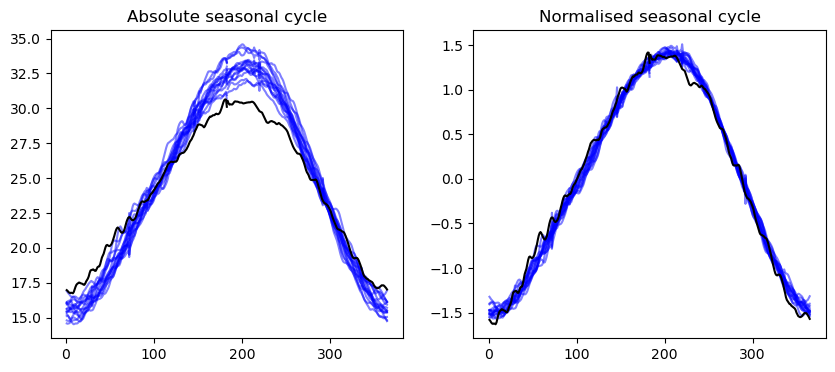

In [35]:
fig, axs = plt.subplots(ncols = 2, dpi = 100, figsize = (10,4))

axs[1]
for i in range(15):
    ukcp = ukcp_sc.isel(ensemble_member = i)
    axs[0].plot(ukcp_sc.doy_adj, ukcp, color = "blue", alpha = 0.5)
    axs[1].plot(ukcp_sc.doy_adj, (ukcp - ukcp.mean()) / ukcp.std(), color = "blue", alpha = 0.5)
    
axs[0].plot(era5_sc.doy_adj, era5_sc, color = "k")
axs[0].set_title("Absolute seasonal cycle")
axs[1].plot(era5_sc.doy_adj, (era5_sc - era5_sc.mean()) / era5_sc.std(), color = "k")
axs[1].set_title("Normalised seasonal cycle")

plt.savefig("ukcp-seasonal.png")

#### **Spatial pattern**

In [28]:
era5_sp = decode_times(xr.open_dataset("data/era5_tmax_daily_extended_-80--40E_-50--10N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_-1_max_30_7v.nc", decode_times = False)).max_tmax.mean("time").load()
ukcp_sp = xr.open_mfdataset("data/ukcp-land-gcm/*spatial*").tasmax.load().sel(longitude = slice(-80, None))
sf = gpd.read_file("study-region_AR-PY").to_crs(cartopy.crs.PlateCarree())

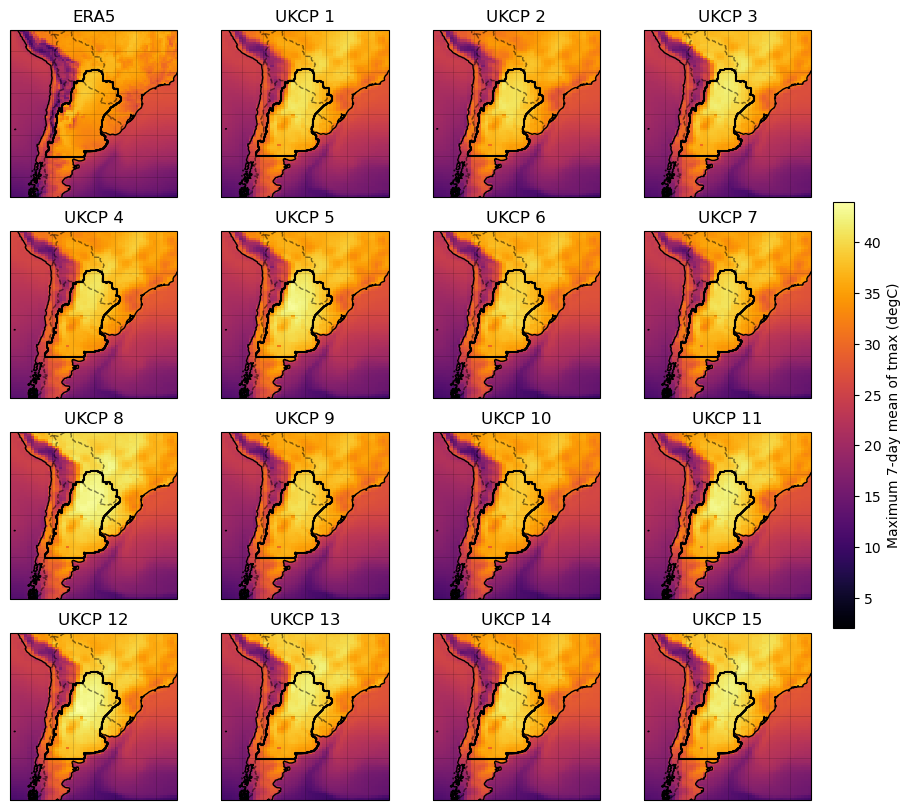

In [29]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, dpi = 100, figsize = (11,10), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

kwargs = {"cmap" : "inferno", "vmin" : 2, "vmax" : 44, "add_colorbar" : False}

cbar = era5_sp.plot(ax = axs[0,0], **kwargs)
axs[0,0].set_title("ERA5")

for i in range(15):
    
    ax = plt.gcf().axes[i+1]
    ukcp = ukcp_sp.isel(ensemble_member = i)
    ukcp.plot(ax = ax, **kwargs)
    ax.set_title("UKCP "+str(i+1))
    
for ax in plt.gcf().axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=False, alpha=0.2)
    
plt.colorbar(cbar, ax = axs, label = "Maximum 7-day mean of tmax (degC)", shrink = 0.9, fraction = 0.025, pad = 0.025)

plt.savefig("ukcp-spatial.png")

#### **Prep data for upload to Climate Explorer**

In [255]:
ukcp_ts = xr.open_mfdataset("data/ukcp-land-gcm/*ts*").tasmax.load()
ukcp_ts = ukcp_ts.assign_coords(time = ukcp_ts.time.dt.year).round(5).to_pandas().transpose()

In [263]:
for i in range(15):
    
    csv_fnm = "ts/AR-PY_tasmax-7day_UKCP-land-gcm_"+str(i+1).rjust(2, "0")+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: UKCP-land-gcm ("+str(i+1).rjust(2, "0")+") max temperatures Argentina/Paraguay heatwave 2022, c.barnes22@imperial.ac.uk"
    str2 = "# temperature [degC] 7-day max tmax Argentina/Paraguay at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tmax"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    ukcp_ts[[i+1]].to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **Results of Climate Explorer trend analysis**

---
### **HighResMIP**

#### **Seasonal cycle**

In [30]:
era5_sc = xr.open_dataset("data/era5_AR-PY_daily.nc").tmax.rolling(time = 7).mean().groupby("time.dayofyear").mean()
era5_sc = era5_sc.assign_coords(doy_adj = ("dayofyear", (era5_sc.dayofyear.values + 183) % 366))
era5_sc[182] = np.nan

hres_sc = xr.concat([xr.open_dataset(fnm).reset_coords(drop = True).expand_dims(run = [fnm]) for fnm in glob.glob("data/highresmip/*seasonal*")], "run").tasmax
hres_sc = hres_sc.assign_coords(doy_adj = ("dayofyear", (hres_sc.dayofyear.values + 183) % 366))
hres_sc[:,182] = np.nan

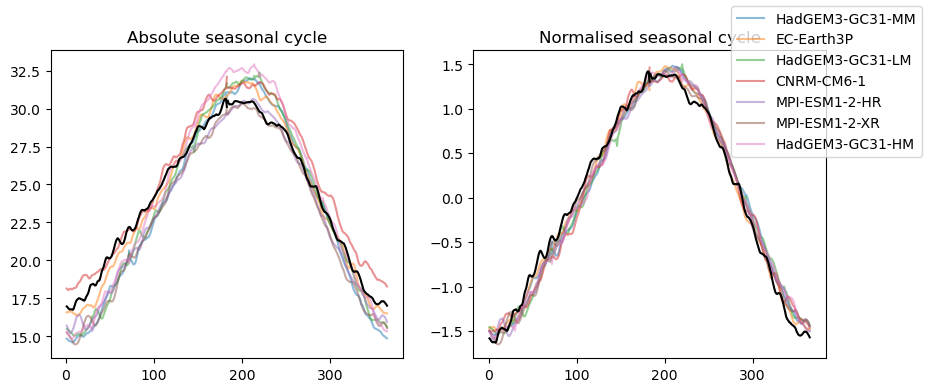

In [32]:
fig, axs = plt.subplots(ncols = 2, dpi = 100, figsize = (10,4))

for i in range(len(hres_sc.run)):
    hres = hres_sc.isel(run = i)
    axs[0].plot(hres.doy_adj, hres, alpha = 0.5, label = re.sub("-highres.+", "", hres.run.values.tolist().split("_")[3]))
    axs[1].plot(hres.doy_adj, (hres - hres.mean()) / hres.std(), alpha = 0.5)
    
axs[0].plot(era5_sc.doy_adj, era5_sc, color = "k")
axs[0].set_title("Absolute seasonal cycle")
axs[1].plot(era5_sc.doy_adj, (era5_sc - era5_sc.mean()) / era5_sc.std(), color = "k")
axs[1].set_title("Normalised seasonal cycle")

fig.legend()

plt.savefig("highresmip-seasonal.png")


#### **Spatial pattern**

In [33]:
era5_sp = decode_times(xr.open_dataset("data/era5_tmax_daily_extended_-80--40E_-50--10N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_-1_max_30_7v.nc", decode_times = False)).max_tmax.mean("time").load()
sf = gpd.read_file("study-region_AR-PY").to_crs(cartopy.crs.PlateCarree())

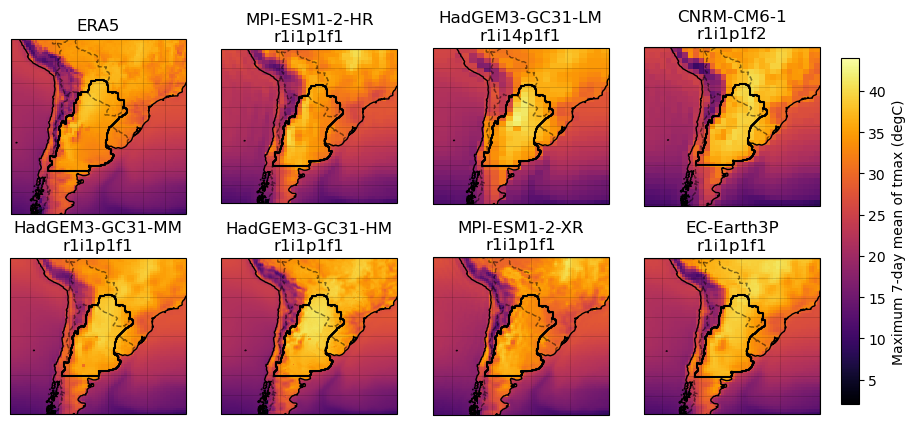

In [34]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, dpi = 100, figsize = (11,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

kwargs = {"cmap" : "inferno", "vmin" : 2, "vmax" : 44, "add_colorbar" : False}

cbar = era5_sp.plot(ax = axs[0,0], **kwargs)
axs[0,0].set_title("ERA5")

fl = glob.glob("data/highresmip/*spatial*")
for i in range(len(fl)):
    
    ax = plt.gcf().axes[i+1]
    xr.open_dataset(fl[i]).reset_coords(drop = True).tasmax.plot(ax = ax, **kwargs)
    ax.set_title(re.sub("-highresSST-future-", "\n", fl[i].split("_")[3]))
    
for ax in plt.gcf().axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=False, alpha=0.2)
    
plt.colorbar(cbar, ax = axs, label = "Maximum 7-day mean of tmax (degC)", shrink = 0.9, fraction = 0.025, pad = 0.025)

plt.savefig("highresmip-spatial.png")

#### **Prep data for upload to Climate Explorer**

In [342]:
for fnm in glob.glob("data/highresmip/*ts*"):
    
    csv_fnm = re.sub("_ts.+2050.nc", ".dat", re.sub("-highresSST-future-", "_", "ts/"+fnm.split("/")[-1]))
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: HighResMIP ("+re.sub(".dat", "", "_".join(csv_fnm.split("_")[3:]))+") max temperatures Argentina/Paraguay heatwave 2022, c.barnes22@imperial.ac.uk"
    str2 = "# temperature [degC] 7-day max tmax Argentina/Paraguay at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tmax"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    ds = xr.open_dataset(fnm).reset_coords(drop = True).tasmax
    ds = ds.assign_coords(time = ds.time.dt.year)
    
    ds.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **Results of Climate Explorer trend analysis**

In [21]:
# get all filenames
" ".join(["t_AR-PY_tasmax-7day_UKCP-land-gcm_"+str(i+1).rjust(2,"0")+":t_ukcp-land-gcm_gsat-aw_sm_"+str(i+1).rjust(2,"0") for i in range(15)])

't_AR-PY_tasmax-7day_UKCP-land-gcm_01:t_ukcp-land-gcm_gsat-aw_sm_01 t_AR-PY_tasmax-7day_UKCP-land-gcm_02:t_ukcp-land-gcm_gsat-aw_sm_02 t_AR-PY_tasmax-7day_UKCP-land-gcm_03:t_ukcp-land-gcm_gsat-aw_sm_03 t_AR-PY_tasmax-7day_UKCP-land-gcm_04:t_ukcp-land-gcm_gsat-aw_sm_04 t_AR-PY_tasmax-7day_UKCP-land-gcm_05:t_ukcp-land-gcm_gsat-aw_sm_05 t_AR-PY_tasmax-7day_UKCP-land-gcm_06:t_ukcp-land-gcm_gsat-aw_sm_06 t_AR-PY_tasmax-7day_UKCP-land-gcm_07:t_ukcp-land-gcm_gsat-aw_sm_07 t_AR-PY_tasmax-7day_UKCP-land-gcm_08:t_ukcp-land-gcm_gsat-aw_sm_08 t_AR-PY_tasmax-7day_UKCP-land-gcm_09:t_ukcp-land-gcm_gsat-aw_sm_09 t_AR-PY_tasmax-7day_UKCP-land-gcm_10:t_ukcp-land-gcm_gsat-aw_sm_10 t_AR-PY_tasmax-7day_UKCP-land-gcm_11:t_ukcp-land-gcm_gsat-aw_sm_11 t_AR-PY_tasmax-7day_UKCP-land-gcm_12:t_ukcp-land-gcm_gsat-aw_sm_12 t_AR-PY_tasmax-7day_UKCP-land-gcm_13:t_ukcp-land-gcm_gsat-aw_sm_13 t_AR-PY_tasmax-7day_UKCP-land-gcm_14:t_ukcp-land-gcm_gsat-aw_sm_14 t_AR-PY_tasmax-7day_UKCP-land-gcm_15:t_ukcp-land-gcm_gsat-aw_

In [60]:
stn_res = pd.read_csv("cx/cx_attribution-ukcp.txt", skiprows = 1, sep = " ", index_col = "run")
stn_res.index = [s[-1] for s in stn_res.index.str.split("_")]
stn_res = stn_res[stn_res.columns[1:]]

In [65]:
# parameters
stn_res[["sigma_est", "sigma_lower", "sigma_upper", "xi_est","xi_lower", "xi_upper", "rv",
         "pr_est", "pr_lower", "pr_upper", "di_est", "di_lower", "di_upper"]]

,sigma_est,sigma_lower,sigma_upper,xi_est,xi_lower,xi_upper,rv,pr_est,pr_lower,pr_upper,di_est,di_lower,di_upper
01,1.055,0.888,1.184,-0.293,-0.450,-0.157,40.471,52906.0000,16.1090,1000000.00,1.446,0.567,2.121
02,1.033,0.822,1.164,-0.172,-0.330,-0.023,41.148,254.8200,10.2590,1000000.00,2.222,1.463,3.009
03,0.841,0.683,0.951,-0.165,-0.272,-0.052,40.511,71.7920,9.8339,1000000.00,1.588,1.106,2.037
04,0.983,0.776,1.128,-0.218,-0.349,-0.067,39.867,156.1900,8.0654,1000000.00,1.576,0.997,2.200
05,1.078,0.823,1.244,-0.200,-0.365,0.043,42.253,47.4330,3.3625,1000000.00,1.605,0.892,2.435
06,0.731,0.603,0.821,-0.147,-0.313,0.019,40.358,819.4400,12.9330,1000000.00,2.017,1.505,2.509
07,0.942,0.749,1.077,-0.206,-0.404,-0.103,40.064,791.0900,23.6440,1000000.00,1.855,1.311,2.452
08,0.805,0.639,0.936,-0.263,-0.403,-0.142,41.246,816.1500,7.2460,1000000.00,1.160,0.488,1.872
09,0.937,0.709,1.119,-0.063,-0.163,0.104,40.499,9.2259,3.3691,204.43,1.629,1.108,2.121
10,0.772,0.641,0.871,-0.244,-0.382,-0.101,38.424,77494.0000,9.1032,1000000.00,1.438,0.827,2.141


In [72]:
# future PR / intensity change
pd.merge(1/stn_res[["f_pr_est", "f_pr_upper", "f_pr_lower"]], 0 - stn_res[["f_di_est", "f_di_upper", "f_di_lower"]], left_index = True, right_index = True)

,f_pr_est,f_pr_upper,f_pr_lower,f_di_est,f_di_upper,f_di_lower
01,5.879932,3.609587,50.027515,0.837,0.651,1.025
02,7.763372,4.658747,60.313631,1.272,1.109,1.433
03,5.700929,3.856091,15.711166,1.036,0.846,1.244
04,3.800114,2.869770,5.780681,1.085,0.887,1.265
05,3.829510,2.338415,8.122157,0.828,0.647,1.010
06,8.979885,4.684060,36.033439,1.032,0.909,1.171
07,5.571651,3.729534,31.906069,1.229,0.999,1.453
08,3.525969,2.747781,6.654245,1.009,0.786,1.218
09,3.635835,2.544983,6.550075,1.022,0.855,1.184
10,5.573825,4.133256,8.685833,1.054,0.889,1.214


In [55]:
stn_res

,sigma_est,sigma_lower,sigma_upper,xi_est,xi_lower,xi_upper,alpha_est,alpha_lower,alpha_upper,rv,...,f_di_upper,f_alpha_est,f_alpha_lower,f_alpha_upper,f_pr_est_i,f_pr_lower_i,f_pr_upper_i,f_di_est_i,f_di_lower_i,f_di_upper_i
01,1.055,0.888,1.184,-0.293,-0.450,-0.157,1.205,0.533,1.746,40.471,...,-0.651,1.046,0.814,1.282,5.879932,3.609587,4.002526,0.837,0.651,1.025
02,1.033,0.822,1.164,-0.172,-0.330,-0.023,1.852,1.169,2.507,41.148,...,-1.109,1.590,1.386,1.791,7.763372,4.658747,5.031036,1.272,1.109,1.433
03,0.841,0.683,0.951,-0.165,-0.272,-0.052,1.323,0.931,1.720,40.511,...,-0.846,1.294,1.057,1.555,5.700929,3.856091,0.571094,1.036,0.846,1.244
04,0.983,0.776,1.128,-0.218,-0.349,-0.067,1.314,0.789,1.877,39.867,...,-0.887,1.356,1.108,1.581,3.800114,2.869770,5.780681,1.085,0.887,1.265
05,1.078,0.823,1.244,-0.200,-0.365,0.043,1.338,0.705,1.932,42.253,...,-0.647,1.035,0.808,1.263,3.829510,2.338415,8.122157,0.828,0.647,1.010
06,0.731,0.603,0.821,-0.147,-0.313,0.019,1.681,1.272,2.095,40.358,...,-0.909,1.290,1.137,1.464,8.979885,4.684060,2.603227,1.032,0.909,1.171
07,0.942,0.749,1.077,-0.206,-0.404,-0.103,1.546,1.023,2.060,40.064,...,-0.999,1.537,1.249,1.817,5.571651,3.729534,2.190515,1.229,0.999,1.453
08,0.805,0.639,0.936,-0.263,-0.403,-0.142,0.967,0.402,1.527,41.246,...,-0.786,1.261,0.982,1.522,3.525969,2.747781,6.654245,1.009,0.786,1.218
09,0.937,0.709,1.119,-0.063,-0.163,0.104,1.358,0.926,1.743,40.499,...,-0.855,1.277,1.068,1.479,3.635835,2.544983,6.550075,1.022,0.855,1.184
10,0.772,0.641,0.871,-0.244,-0.382,-0.101,1.198,0.676,1.767,38.424,...,-0.889,1.317,1.111,1.518,5.573825,4.133256,8.685833,1.054,0.889,1.214
